In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

## Data Preparation
#### [FashionMNIST available in PyTorch Datasets](https://pytorch.org/docs/stable/_modules/torchvision/datasets/mnist.html#FashionMNIST)

In [2]:
# Tranforms applied on Original Dataset

transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
        ])

train_set = datasets.FashionMNIST('./torchdataset/', train=True, download=True, transform=transform)
val_test_set = datasets.FashionMNIST('./torchdataset/', train=False, download=True, transform=transform)

0it [00:00, ?it/s]

Extracting ./torchdataset/FashionMNIST\raw\train-images-idx3-ubyte.gz to ./torchdataset/FashionMNIST\raw


0it [00:00, ?it/s]

Extracting ./torchdataset/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./torchdataset/FashionMNIST\raw


0it [00:00, ?it/s]

Extracting ./torchdataset/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./torchdataset/FashionMNIST\raw


0it [00:00, ?it/s]

Extracting ./torchdataset/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./torchdataset/FashionMNIST\raw
Processing...
Done!


c:\programdata\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# Classes/Labels in Fashion-MNIST Dataset

classes = train_set.classes
classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [4]:
def get_train_test_split(targets_arr, num_classes=10, test_size=2000):
    '''
    Split a dataset into two in a stratified manner and return the indices of each split
    Input: Targets of Dataset as a List type
    Output: Spit given input into two list of indices based on the index of Targets List    
    '''
    test_labels = {}
    each_class = test_size/num_classes
    for i in range(num_classes):
        test_labels[i] = 0
    val_indices = []
    test_indices = []
    for i in range(len(targets_arr)):
        if test_labels[targets_arr[i]] < each_class:
            test_indices.append(i)
            test_labels[targets_arr[i]] += 1
        else:
            val_indices.append(i)
    return val_indices, test_indices

In [5]:
# Split the test data indices (10000 samples) to validation (8000 samples) and test indices (2000 samples)
# Performed a stratified split

valid_indices, test_indices = get_train_test_split(val_test_set.targets.numpy())

In [6]:
# Using above indices split test dataset (10000 samples) to validation (8000 samples) and test set (2000 samples)

valid_set = torch.utils.data.Subset(val_test_set, valid_indices)
test_set = torch.utils.data.Subset(val_test_set, test_indices)

In [7]:
def get_train_valid_test_loaders(train_set, valid_set, test_set, batch_size=128, num_workers=4):
    '''
    Input: Train, Validation, Test datasets (also Batch Size)
    Output: Train, Validation, Test Loaders
    '''
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, valid_loader, test_loader

## Dataset Analysis and Visualization

In [8]:
# Get Train, Validation and Test loaders from Train, Validation and Test sets (here batch_size=1)

train_loader, valid_loader, test_loader = get_train_valid_test_loaders(train_set, valid_set, test_set, 
                                                                       batch_size=1, num_workers=4)

In [9]:
def view_data_samples(data_loader, classes):
    '''
    This function shows the sample images for each class from the passed data_loader 
    '''
    label_names = classes
    printed = {}
    axs = [(2,5,1), (2,5,2), (2,5,3), (2,5,4), (2,5,5), (2,5,6), (2,5,7), (2,5,8), (2,5,9), (2,5,10)]
    plt.figure(0, figsize=(15, 7))
    i = 0
    for cur_item in data_loader:
        cur_class = cur_item[1].item()
        if len(printed) == 10:
            break
        if cur_class not in printed:
            plt.subplot(*axs[i]), plt.imshow(cur_item[0][0].permute(1, 2, 0), cmap='gray')
            plt.title(label_names[cur_class])
            printed[cur_class] = 1
            i += 1

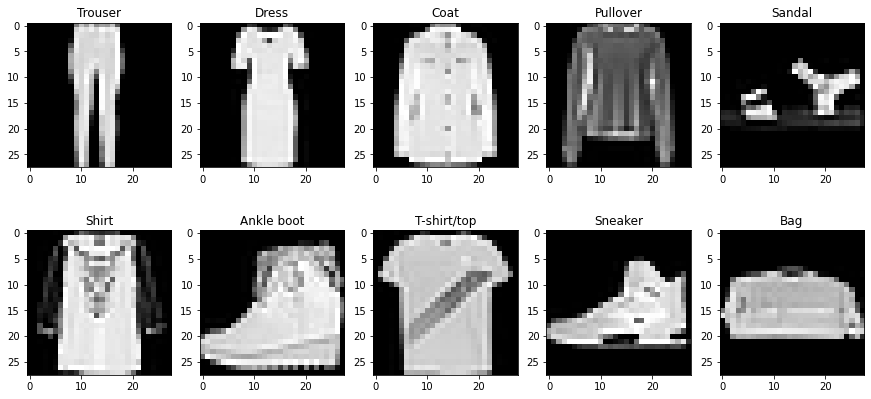

In [10]:
# To view one sample from each class of the Dataset

view_data_samples(train_loader, classes)

In [11]:
def get_data_stats(data_loader, label_names):
    '''
    Return a dictionary with each class/label as a key and its no. of samples as its value
    '''
    classes = {}
    for item in data_loader:
        curClass = item[1].item()
        if label_names[curClass] not in classes:
            classes[label_names[curClass]] = 1
        else:
            classes[label_names[curClass]] += 1
    return classes

In [12]:
train_set_stats = get_data_stats(train_loader, classes)
print(f"No.of Samples in Train Set = {sum(list(train_set_stats.values()))}")
train_set_stats

No.of Samples in Train Set = 60000


{'Dress': 6000,
 'Sneaker': 6000,
 'Coat': 6000,
 'Shirt': 6000,
 'Pullover': 6000,
 'Trouser': 6000,
 'Sandal': 6000,
 'Bag': 6000,
 'T-shirt/top': 6000,
 'Ankle boot': 6000}

In [13]:
valid_set_stats = get_data_stats(valid_loader, classes)
print(f"No.of Samples in Validation Set = {sum(list(valid_set_stats.values()))}")
valid_set_stats

No.of Samples in Validation Set = 8000


{'Coat': 800,
 'Pullover': 800,
 'Trouser': 800,
 'Sneaker': 800,
 'Shirt': 800,
 'T-shirt/top': 800,
 'Sandal': 800,
 'Dress': 800,
 'Bag': 800,
 'Ankle boot': 800}

In [14]:
test_set_stats = get_data_stats(test_loader, classes)
print(f"No.of Samples in Test Set = {sum(list(test_set_stats.values()))}")
test_set_stats

No.of Samples in Test Set = 2000


{'Ankle boot': 200,
 'Pullover': 200,
 'Trouser': 200,
 'Shirt': 200,
 'Coat': 200,
 'Sandal': 200,
 'Sneaker': 200,
 'Dress': 200,
 'Bag': 200,
 'T-shirt/top': 200}

In [15]:
data_split_stats = {'Train':len(train_loader), 'Validation':len(valid_loader), 'Test':len(test_loader)}
data_split_stats

{'Train': 60000, 'Validation': 8000, 'Test': 2000}

In [16]:
def display_plot(dataset_stats, xlabel="No. of Samples", ylabel="Classes", title='', color='royalblue'):
    '''
    Plots the passed dataset_stats dictionary with its keys as Labels and values as no. of samples for that label
    '''
    labels = list(dataset_stats.keys())
    n_samples = list(dataset_stats.values())
    plt.figure(figsize=(13, 5))
    # creating the bar plot 
    plt.barh(labels, n_samples, color='royalblue')
    for label, samples in zip(labels, n_samples):
        plt.text(samples, label, str(samples), color='red')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

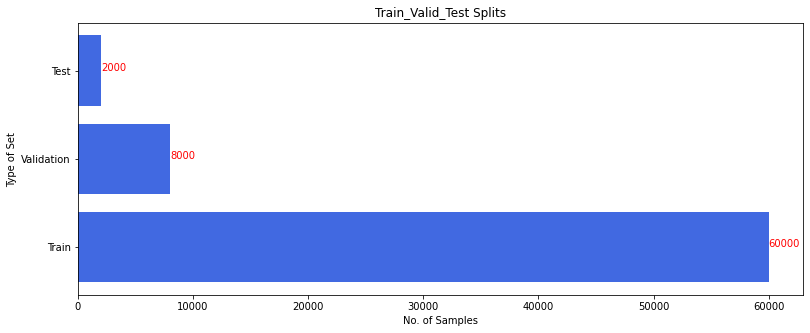

In [17]:
# Train_Validation_Test Split Bar Chart

display_plot(data_split_stats, ylabel="Type of Set", title="Train_Valid_Test Splits")

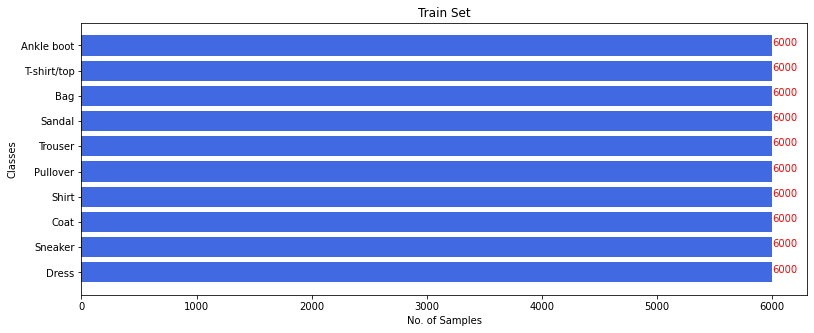

In [18]:
# Train Set Bar Chart for each class

display_plot(train_set_stats, title="Train Set")

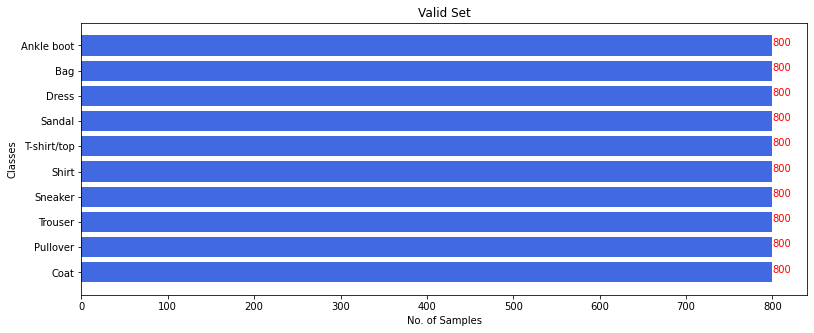

In [19]:
# Validation Set Bar Chart for each class

display_plot(valid_set_stats, title="Valid Set")

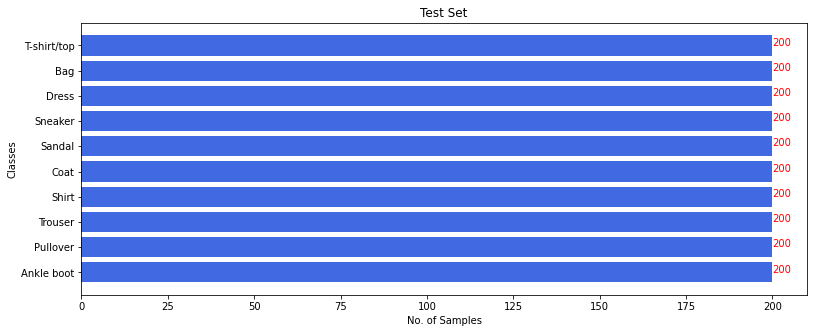

In [20]:
# Test Set Bar Chart for each class

display_plot(test_set_stats, title="Test Set")

## CNN Model with Dropout

In [21]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.batch_norm2 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64*6*6, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.out = nn.Linear(128, 10)
        
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        
    def forward(self, X):
        X = F.max_pool2d(self.batch_norm1(F.relu(self.conv1(X))), 2)
        X = F.max_pool2d(self.batch_norm2(F.relu(self.conv2(X))), 2)
        X = X.view(-1, 64*6*6)
        X = F.relu(self.fc1(X))
        X = self.dropout2(X)
        X = F.relu(self.fc2(X))
        X = self.dropout2(X)
        X = F.relu(self.fc3(X))
        X = self.dropout2(X)
        X = F.relu(self.fc4(X))
        X = self.dropout1(X)
        X = self.out(X)   
        return X

In [22]:
# Above Model Architecture. Needs torchsummary library

summary(ConvNet().to("cuda"), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
            Conv2d-3           [-1, 64, 12, 12]          18,496
       BatchNorm2d-4           [-1, 64, 12, 12]             128
            Linear-5                 [-1, 1024]       2,360,320
           Dropout-6                 [-1, 1024]               0
            Linear-7                  [-1, 512]         524,800
           Dropout-8                  [-1, 512]               0
            Linear-9                  [-1, 256]         131,328
          Dropout-10                  [-1, 256]               0
           Linear-11                  [-1, 128]          32,896
          Dropout-12                  [-1, 128]               0
           Linear-13                   [-1, 10]           1,290
Total params: 3,069,642
Trainable param

## CNN Model without using Dropout

In [8]:
class ConvNetNoDropout(nn.Module):
    def __init__(self):
        super(ConvNetNoDropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.batch_norm2 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64*6*6, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.out = nn.Linear(128, 10)
        
        
    def forward(self, X):
        X = F.max_pool2d(self.batch_norm1(F.relu(self.conv1(X))), 2)
        X = F.max_pool2d(self.batch_norm2(F.relu(self.conv2(X))), 2)
        X = X.view(-1, 64*6*6)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = F.relu(self.fc4(X))
        X = self.out(X)   
        return X

## Training & Evaluation

In [23]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    losses = []
    correct = 0
    for batch_idx, batch_sample in enumerate(train_loader):
        data, target = batch_sample
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss = float(np.mean(losses))
    train_acc = correct / ((batch_idx+1) * config.batch_size)
    print('Train set: Loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        float(np.mean(losses)), correct, (batch_idx+1) * config.batch_size,
        100. * correct / ((batch_idx+1) * config.batch_size)))
    return train_loss, train_acc

In [24]:
def validation(model, device, valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, sample in enumerate(valid_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target, reduction='sum')
            valid_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    valid_loss /= len(valid_loader.dataset)
    accuracy = 100. * correct / len(valid_loader.dataset)
    print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        valid_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))
    return valid_loss, accuracy

In [25]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, target = sample
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target, reduction='sum')
            test_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, accuracy

In [26]:
def main(config, model):
    is_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if is_cuda else "cpu")
    print("Selected Torch Device: ", device)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=1e-8)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=4)

    if config.cp_dir:
        checkpoint = torch.load(config.cp_dir)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
    
    train_loader, valid_loader, test_loader = get_train_valid_test_loaders(train_set, 
                                                                           valid_set, 
                                                                           test_set, 
                                                                           batch_size=config.batch_size, 
                                                                           num_workers=4)

    best_accuracy = 0.0
    writer = SummaryWriter("runs/"+config.plots_dir, comment=f'LR_{config.learning_rate}_BS_{config.batch_size}')

    for epoch in range(1, config.num_epochs+1):
        print(f'\nepoch #{epoch}')
        train_loss, train_accuracy = train(model, device, train_loader, 
                                           optimizer, criterion, epoch)
        valid_loss, valid_accuracy = validation(model, device, valid_loader)
        test_loss, test_accuracy = test(model, device, test_loader)
        scheduler.step(valid_loss)
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/valid', valid_loss, epoch)
        writer.add_scalar('Loss/test', test_loss, epoch)
        writer.add_scalar('Accuracy/train', train_accuracy, epoch)
        writer.add_scalar('Accuracy/valid', valid_accuracy, epoch)
        writer.add_scalar('Accuracy/test', test_accuracy, epoch)        
        writer.add_scalar('LR', optimizer.param_groups[0]['lr'], epoch)
        if test_accuracy > best_accuracy and config.save_dir:
            best_accuracy = test_accuracy
            save_file_path = os.path.join(config.save_dir, 'model_{}_{:2.2f}.pth'.format(epoch, best_accuracy))
            states = {
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'best_accuracy': best_accuracy
            }
            try:
                os.mkdir(config.save_dir)
            except:
                pass
            torch.save(states, save_file_path)
            print('Model saved ', str(save_file_path))
    writer.flush()
    writer.close()
    print('Training Finished')

## Set Configuration

In [27]:
class Config:
    def __init__(self, learning_rate=0.001, num_epochs=25, batch_size=128, plots_dir='plots', save_dir='./checkpoints/', cp_dir=''):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.cp_dir = cp_dir
        self.plots_dir = plots_dir
        self.save_dir = save_dir

## ConvNet (With Dropout, Random Horizontal Flips used)

In [28]:
# ConvNet with dropout

model = ConvNet()
config = Config(plots_dir='convnet_dropout')
main(config, model)

Selected Torch Device:  cuda

epoch #1
Train set: Loss: 0.5529, Accuracy: 48262/60032 (80.39%)
Validation set: Average loss: 0.3430, Accuracy: 7048/8000 (88.10%)
Test set: Average loss: 0.3172, Accuracy: 1798/2000 (89.90%)
Model saved  ./checkpoints/model_1_89.90.pth

epoch #2
Train set: Loss: 0.3360, Accuracy: 53186/60032 (88.60%)
Validation set: Average loss: 0.3114, Accuracy: 7099/8000 (88.74%)
Test set: Average loss: 0.2955, Accuracy: 1789/2000 (89.45%)

epoch #3
Train set: Loss: 0.2904, Accuracy: 54117/60032 (90.15%)
Validation set: Average loss: 0.2687, Accuracy: 7237/8000 (90.46%)
Test set: Average loss: 0.2510, Accuracy: 1825/2000 (91.25%)
Model saved  ./checkpoints/model_3_91.25.pth

epoch #4
Train set: Loss: 0.2688, Accuracy: 54500/60032 (90.78%)
Validation set: Average loss: 0.2655, Accuracy: 7258/8000 (90.72%)
Test set: Average loss: 0.2457, Accuracy: 1830/2000 (91.50%)
Model saved  ./checkpoints/model_4_91.50.pth

epoch #5
Train set: Loss: 0.2500, Accuracy: 54959/60032 (91

## ConvNet (Without Dropout, Random Horizontal Flips used)

In [16]:
# ConvNet without dropout

model = ConvNetNoDropout()
config = Config(plots_dir='convnet_no_dropout')
main(config, model)

Selected Torch Device:  cuda

epoch #1
Train set: Loss: 0.3694, Accuracy: 51921/60032 (86.49%)
Validation set: Average loss: 0.3535, Accuracy: 6999/8000 (87.49%)
Test set: Average loss: 0.3262, Accuracy: 1779/2000 (88.95%)
Model saved  ./checkpoints/model_1_88.95.pth

epoch #2
Train set: Loss: 0.2326, Accuracy: 55043/60032 (91.69%)
Validation set: Average loss: 0.2498, Accuracy: 7309/8000 (91.36%)
Test set: Average loss: 0.2283, Accuracy: 1847/2000 (92.35%)
Model saved  ./checkpoints/model_2_92.35.pth

epoch #3
Train set: Loss: 0.1854, Accuracy: 56008/60032 (93.30%)
Validation set: Average loss: 0.2290, Accuracy: 7358/8000 (91.97%)
Test set: Average loss: 0.2380, Accuracy: 1847/2000 (92.35%)

epoch #4
Train set: Loss: 0.1510, Accuracy: 56621/60032 (94.32%)
Validation set: Average loss: 0.2628, Accuracy: 7267/8000 (90.84%)
Test set: Average loss: 0.2725, Accuracy: 1808/2000 (90.40%)

epoch #5
Train set: Loss: 0.1253, Accuracy: 57246/60032 (95.36%)
Validation set: Average loss: 0.2878, A